In [1]:
# Import modules
import datetime
import spiceypy
import numpy as np
import pandas as pd

# Load the SPICE kernels via a meta file
spiceypy.furnsh('kernel_meta.txt')

# We want to compute miscellaneous positions w.r.t. the centre of
# the Sun for a certain time interval.
# First, we set an initial time in UTC.
INIT_TIME_UTC = datetime.datetime(year=2000, month=1, day=1, \
                                  hour=0, minute=0, second=0)

# Add a number of days; you can play around with the datetime variables; but
# leave it as it is for the first try, since other computations and comments
# are based on this value.
DELTA_DAYS = 10000
END_TIME_UTC = INIT_TIME_UTC + datetime.timedelta(days=DELTA_DAYS)

# Convert the datetime objects now to strings
INIT_TIME_UTC_STR = INIT_TIME_UTC.strftime('%Y-%m-%dT%H:%M:%S')
END_TIME_UTC_STR = END_TIME_UTC.strftime('%Y-%m-%dT%H:%M:%S')

# Print the starting and end times
print('Init time in UTC: %s' % INIT_TIME_UTC_STR)
print('End time in UTC: %s\n' % END_TIME_UTC_STR)

# Convert to Ephemeris Time (ET) using the SPICE function utc2et
INIT_TIME_ET = spiceypy.utc2et(INIT_TIME_UTC_STR)
END_TIME_ET = spiceypy.utc2et(END_TIME_UTC_STR)

# Create a numpy array that covers a time interval in delta = 1 day step
TIME_INTERVAL_ET = np.linspace(INIT_TIME_ET, END_TIME_ET, DELTA_DAYS)

Init time in UTC: 2000-01-01T00:00:00
End time in UTC: 2027-05-19T00:00:00



In [2]:
# Using km is not intuitive. AU would scale it too severely. Since we compute
# the Solar System Barycentre (SSB) w.r.t. the Sun; and since we expect it to
# be close to the Sun, we scale the x, y, z component w.r.t the radius of the
# Sun. We extract the Sun radii (x, y, z components of the Sun ellipsoid) and
# use the x component
_, RADII_SUN = spiceypy.bodvcd(bodyid=10, item='RADII', maxn=3)

RADIUS_SUN = RADII_SUN[0]

In [3]:
# All our computed parameters, positions etc. shall be stored in a pandas
# dataframe. First, we create an empty one
SOLAR_SYSTEM_DF = pd.DataFrame()

# Set the column ET that stores all ETs
SOLAR_SYSTEM_DF.loc[:, 'ET'] = TIME_INTERVAL_ET

# The column UTC transforms all ETs back to a UTC format. The function
# spicepy.et2datetime is NOT an official part of SPICE (there you can find
# et2utc).
# However this function returns immediately a datetime object
SOLAR_SYSTEM_DF.loc[:, 'UTC'] = \
    SOLAR_SYSTEM_DF['ET'].apply(lambda x: spiceypy.et2datetime(et=x).date())

# Here, the position of the SSB, as seen from the Sun, is computed. Since
# spicepy.spkgps returns the position and the corresponding light time,
# we add the index [0] to obtain only the position array
SOLAR_SYSTEM_DF.loc[:, 'POS_SSB_WRT_SUN'] = \
    SOLAR_SYSTEM_DF['ET'].apply(lambda x: spiceypy.spkgps(targ=0, \
                                                          et=x, \
                                                          ref='ECLIPJ2000', \
                                                          obs=10)[0])

# Now the SSB position vector is scaled with the Sun's radius
SOLAR_SYSTEM_DF.loc[:, 'POS_SSB_WRT_SUN_SCALED'] = \
    SOLAR_SYSTEM_DF['POS_SSB_WRT_SUN'].apply(lambda x: x / RADIUS_SUN)

# Finally the distance between the Sun and the SSB is computed. The length
# (norm) of the vector needs to be determined with the SPICE function vnorm().
# numpy provides an identical function in: numpy.linalg.norm()
SOLAR_SYSTEM_DF.loc[:, 'SSB_WRT_SUN_SCALED_DIST'] = \
    SOLAR_SYSTEM_DF['POS_SSB_WRT_SUN_SCALED'].apply(lambda x: \
                                                    spiceypy.vnorm(x))

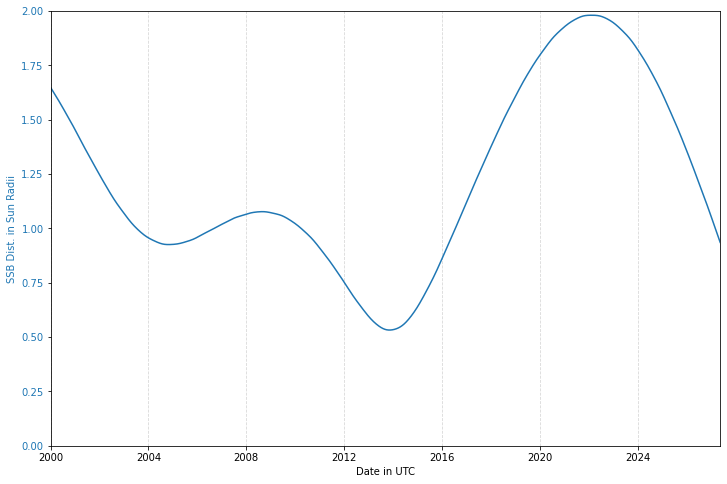

In [4]:
# Import the matplotlib library
from matplotlib import pyplot as plt

# Set a figure
FIG, AX = plt.subplots(figsize=(12, 8))

# Plot the distance between the Sun and the SSB
AX.plot(SOLAR_SYSTEM_DF['UTC'], SOLAR_SYSTEM_DF['SSB_WRT_SUN_SCALED_DIST'], \
        color='tab:blue')

# Set a label for the x and y axis and color the y ticks accordingly
AX.set_xlabel('Date in UTC')
AX.set_ylabel('SSB Dist. in Sun Radii', color='tab:blue')
AX.tick_params(axis='y', labelcolor='tab:blue')

# Set limits for the x and y axis
AX.set_xlim(min(SOLAR_SYSTEM_DF['UTC']), max(SOLAR_SYSTEM_DF['UTC']))
AX.set_ylim(0, 2)

# Set a grid
AX.grid(axis='x', linestyle='dashed', alpha=0.5)

# Saving the figure in high quality
plt.savefig('SSB2SUN_DISTANCE.png', dpi=300)

In [5]:
# Additionally, we want to compute the position vector of all outer gas
# giants. We define a dictionary with a planet's barycentre abbreviation and
# corresponding NAIF ID code
NAIF_ID_DICT = {'JUP': 5, \
                'SAT': 6, \
                'URA': 7, \
                'NEP': 8}

# Iterate through the dictionary and compute the position vector for each
# planet as seen from the Sun. Further, compute the phase angle between the
# SSB and the planet as seen from the Sun
for planets_name_key in NAIF_ID_DICT:

    # Define the pandas dataframe column for each planet (position and phase
    # angle). Each '%s' substring is replaced with the planets name as
    # indicated after the "%"
    planet_pos_col = 'POS_%s_WRT_SUN' % planets_name_key
    planet_angle_col = 'PHASE_ANGLE_SUN_%s2SSB' % planets_name_key

    # Get the corresponding NAIF ID of the planet's barycentre
    planet_id = NAIF_ID_DICT[planets_name_key]

    # Compute the planet's position as seen from the Sun.
    SOLAR_SYSTEM_DF.loc[:, planet_pos_col] = \
        SOLAR_SYSTEM_DF['ET'].apply(lambda x: \
                                    spiceypy.spkgps(targ=planet_id, \
                                                    et=x, \
                                                    ref='ECLIPJ2000', \
                                                    obs=10)[0])

    # Compute the phase angle between the SSB and the planet as seen from the
    # Sun. Since we apply a lambda function on all columns we need to set
    # axis=1, otherwise we get an error!
    SOLAR_SYSTEM_DF.loc[:, planet_angle_col] = \
        SOLAR_SYSTEM_DF.apply(lambda x: \
                              np.degrees(spiceypy.vsep(x[planet_pos_col], \
                                                       x['POS_SSB_WRT_SUN'])),\
                              axis=1)

In [6]:
# Let's verify the function vsep and compute the phase angle between the SSB
# and Jupiter as seen from the Sun (we use the very first array entries).
# Define a lambda function the computes the angle between two vectors
COMP_ANGLE = lambda vec1, vec2: np.arccos(np.dot(vec1, vec2) \
                                          / (np.linalg.norm(vec1) \
                                             * np.linalg.norm(vec2)))

print('Phase angle between the SSB and Jupiter as seen from the Sun (first ' \
      'array entry, lambda function): %s' % \
      np.degrees(COMP_ANGLE(SOLAR_SYSTEM_DF['POS_SSB_WRT_SUN'].iloc[0], \
                            SOLAR_SYSTEM_DF['POS_JUP_WRT_SUN'].iloc[0])))


print('Phase angle between the SSB and Jupiter as seen from the Sun (first ' \
      'array entry, SPICE vsep function): %s' % \
      np.degrees(spiceypy.vsep(SOLAR_SYSTEM_DF['POS_SSB_WRT_SUN'].iloc[0], \
                               SOLAR_SYSTEM_DF['POS_JUP_WRT_SUN'].iloc[0])))

Phase angle between the SSB and Jupiter as seen from the Sun (first array entry, lambda function): 14.88953374168662
Phase angle between the SSB and Jupiter as seen from the Sun (first array entry, SPICE vsep function): 14.889533741686577


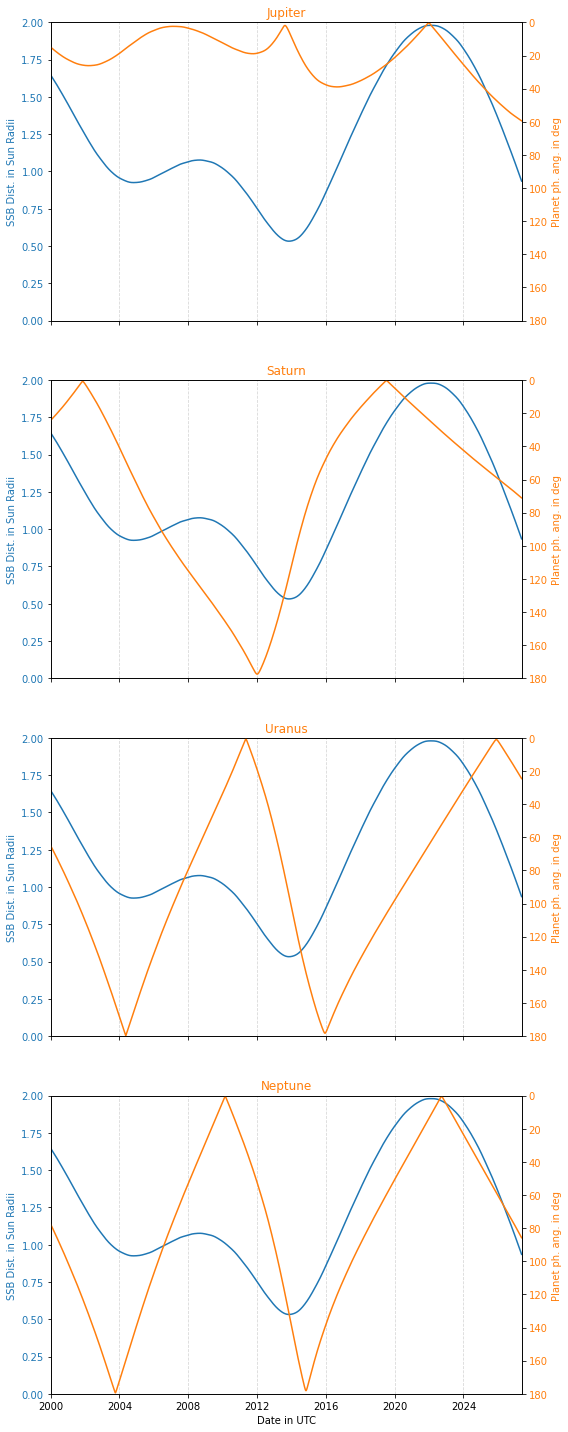

In [7]:
# Create a 4 axes plot where all 4 plots are vertically aligned and share the
# x axis (date in UTC)
FIG, (AX1, AX2, AX3, AX4) = plt.subplots(4, 1, sharex=True, figsize=(8, 20))

# We iterate through the planets (from Jupiter to Neptune) and plot the
# phase angle between the planet and the SSB, as seen from the Sun, in each
# axis individually
for ax_f, planet_abr, planet_name in zip([AX1, AX2, AX3, AX4], \
                                         ['JUP', 'SAT', 'URA', 'NEP'], \
                                         ['Jupiter', 'Saturn', 'Uranus', \
                                          'Neptune']):

    # First, we set the planet's name as the sub plot title (instead of
    # setting a legend)
    ax_f.set_title(planet_name, color='tab:orange')

    # The distance between the SSB and the Sun is plotted.
    ax_f.plot(SOLAR_SYSTEM_DF['UTC'], \
              SOLAR_SYSTEM_DF['SSB_WRT_SUN_SCALED_DIST'], \
              color='tab:blue')

    # A y label is set and the color of labels and ticks are adjusted for
    # better visibility
    ax_f.set_ylabel('SSB Dist. in Sun Radii', color='tab:blue')
    ax_f.tick_params(axis='y', labelcolor='tab:blue')

    # Set x (based on the min and max date) and y limits (the SSB has varying
    # distances between 0 and 2 Sun Radii)
    ax_f.set_xlim(min(SOLAR_SYSTEM_DF['UTC']), max(SOLAR_SYSTEM_DF['UTC']))
    ax_f.set_ylim(0, 2)

    # We add now the phase angle values and copy the x axis for this purpose
    ax_f_add = ax_f.twinx()

    # Plot the phase angle between the SSB and planet as seen from the Sun
    ax_f_add.plot(SOLAR_SYSTEM_DF['UTC'], \
                  SOLAR_SYSTEM_DF['PHASE_ANGLE_SUN_%s2SSB' % planet_abr], \
                  color='tab:orange', \
                  linestyle='-')

    # Set the y label's name and color accordingly
    ax_f_add.set_ylabel('Planet ph. ang. in deg', color='tab:orange')
    ax_f_add.tick_params(axis='y', labelcolor='tab:orange')

    # Invert the y axis and set the limits. We invert the axis so that a
    # possible anti-correlation (large phase angle corresponds to a smaller
    # distance between the Sun's centre and the SSB) becomes more obvious
    ax_f_add.invert_yaxis()
    ax_f_add.set_ylim(180, 0)

    # Set a grid (only date)
    ax_f.grid(axis='x', linestyle='dashed', alpha=0.5)


# Finally we set the x label ...
AX4.set_xlabel('Date in UTC')

# ... tight the figures a bit ...
FIG.tight_layout()

# ... reduce the distance between the axes ...
plt.subplots_adjust(hspace=0.2)

# ... and save the figure in high quality
plt.savefig('PLANETS_SUN_SSB_PHASE_ANGLE.png', dpi=300)